Computing a semi analytical solution to the Sedov-Taylor blast wave with radiation using the semi-analytical solution. 
-------------------------------------------------------------------------------------------------------------------------------------
See Reinicke (1998), Krumholz (2007) or Duval (2020) for discussion of the physics and computational aspects.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Code written by Hannah Duval, Eva Punter and Mathijs Vanrespaille. 
If you use this code in your publication, we kindly request you cite the following report: <br>
H. Duval & E. Punter & M. Vanrespaille, Benchmarking a new RHD-code: The Radiation-Sedov Blast Wave, 2020, KU Leuven

This code is roughly seperated into four parts. Firstly, we define useful constants, which are the primary input parameters. Secondly, many functions are defined to implement the numerical solution. Importantly, there are also functions for finding acceptable values for the two missing parameters given some input. Thirdly, there are some cells where these functions are applied using the same values used by Reinicke and Meyer-ter-Vehn (1991). Lastly, some more plots are made which serve to gain more intuition, noteable in how sensitive the integration is to the unknown values of the two unknown parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as solver

In [2]:
# See the paper by Reinicke and Meyer-Ter-Vehn (1991), which contains the formulae that are implemented here

# Input constants
n = 3          # Level of symmetry, 3 for spherical symmetry
chi_0 = 1      # Constant heat conduction [eq. (4)]
a = -2         # Power dependance of heat conduction on density [eq. (4)]
b = 13/2       # Power dependance of heat conduction on temperature [eq. (4)]
gamma = 5/4    # Adiabatic exponent
g_0 = 1        # Constant density
E_0 = 135      # Energie released in point explosion
Gamma = 1      # Ideal gas law constant

C = [n, a, b]  # Convenient vector containing constants to be given to some functions.

In [3]:
# Constants which are calculated based on the input above

k_p = ( (2*b-1)*n + 2 ) / ( 2*b - 2*a +1 )  
kappa = -k_p                                # Power dependance of density on radius: rho = g_0 r^kappa
alpha = ( 2*b - 2*a + 1 ) / ( 2*b - (n+2)*a + n )  
Omega = 2*chi_0 / ( Gamma**(b+1) * g_0**(1-a) ) * ( E_0 / g_0 )**(b-1/2)   # Measure for the strength of the explosion [eq. 78 in Krumholz (2007)]
sigma = ( 2*b-1 ) / ( alpha*(1-a) )
mu = 2/(gamma-1)

In [4]:
# RHS of eq. (13.a) in Reinicke (1991)
def f1(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    return -2*( 1 + W/(beta * H**(a-1) * Theta**b) )

In [5]:
# RHS of eq. (13.b) in Reinicke (1991)
def f2(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    return sigma - (n+kappa+sigma)*U

In [6]:
# RHS of eq. (13.c) in Reinicke (1991)
def f3(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    return U*(1/alpha-U) + Theta*(2*W/(beta * H**(a-1) * Theta**b) - kappa - sigma)

In [7]:
# RHS of eq. (13.d) in Reinicke (1991)
def f4(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    if Theta < 1.e-10:
        return mu*(1/alpha-1) - n*U - (n+kappa+sigma)*W #waarom?
    else: 
        return W / (beta * H**(a-1) * Theta**b) * (mu*(U-1) + 2*W) + mu*(1/alpha-1) - n*U - (n+kappa+sigma)*W

In [8]:
# Applying the shock conditions [eq. 31]. As input, a vector of four elements is given as input which are then 
# altered and returned into another vector of four elements. 
def shockConditions(y) :
    
    U_out = y[0]
    Theta_out = y[1]
    H_out = y[2]
    W_out = y[3]
    
    U_in = 1 - Theta_out / (1 - U_out)
    Theta_in = Theta_out
    H_in = H_out * (1 - U_out)**2 / Theta_out
    W_in = ( Theta_out*W_out - ((1-U_out)**4-Theta_out**2)/(2*(1-U_out)) ) / (1-U_out)**2
    
    new = (U_in, Theta_in, H_in, W_in)
    return new

In [9]:
# The derivative of U to dimensionless radius xi (note that this is dU/dxi and not the logarithmic derivative)
def dU(xi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return (Theta*f2(y, beta) - (U-1)*f3(y, beta)) / (Theta - (U-1)**2) / xi

In [10]:
# The derivative of Theta to dimensionless radius xi (note that this is dU/dxi and not the logarithmic derivative)
def dTheta(xi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return f1(y, beta)*Theta/xi

In [11]:
# The derivative of H to dimensionless radius xi (note that this is dU/dxi and not the logarithmic derivative)
def dH(xi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return ( f3(y, beta) - (U-1)*f2(y, beta) ) / ( Theta - (U-1)**2 ) * H/xi

In [12]:
# The derivative of W to dimensionless radius xi (note that this is dU/dxi and not the logarithmic derivative)
def dW(xi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return ( f4(y, beta) - ( (W-U+1)*f3(y, beta) + (Theta - (U-1)*W)*f2(y, beta) ) / (Theta - (U-1)**2) ) / xi

In [13]:
# Functie die de vier afgeleiden bijeen brengt. Dit geef je mee aan scipy.integrate.solve_ivp en specifieer dat er een extra argument is door args=[beta] mee te geven.
def update(xi, y, beta) :
    return (dU(xi, y, beta), dTheta(xi, y, beta), dH(xi, y, beta), dW(xi, y, beta))

In [14]:
# integrand [eq. 26.d]
def integrand_IC(y):
    F_y = y**(b-1) * (1-y)**(b-a) * (1-2*y)/(mu - (mu + 1)*y)
    return F_y

# Calculate the initial conditions just inside the radiation front.
def Initial_conditions(xi_f, beta, U_0):

    Int, err = solver.quad(integrand_IC, 0, U_0)
    Fac = -beta*xi_f**((2*b-1)/a)

    ln_x = Fac*Int
    xi_new = np.exp(ln_x)*xi_f #24
    
    #rest 26
    Theta_0 = U_0*(1-U_0)
    G_0 = 1./(1-U_0)
    H_0 = xi_new**(-sigma)*G_0
    W_0 =  (mu - (mu+1)*U_0)/2
    
    return xi_new, [U_0, Theta_0, H_0, W_0]

In [15]:
# Defining the conditions for an 'event', during which this function returns 0. An event occurs when 
# U = 1+sqrt(Theta) or U = 1-sqrt(Theta), as this represents the sound barrier. 
def supersonic(t, y, beta) :
    return (y[0] - (1+np.sqrt(y[1])) ) * (y[0] - (1-np.sqrt(y[1])) )
supersonic.terminal = True # This last addition means the numerical integration is halted when an event occurs.

In [16]:
# Returns the outer and inner solutions in that order, according to the scipy.integrate notation.
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
# As input, it requests four scalars. 
# 1: a guess for the radius of the radiation front, the radius being normalised to one at the shock front.
# 2: the innermost radius. Ideally, we would integrate to xi=0, but this causes a division by zero error. 10^-3 is recommended 
# 3: a guess for the parameter beta_0, see Reinicke&Meyer-ter-Vehn (1991)
# 4: value of U just inside the radiation front. Ideally, we would integrate starting from xi=xi_f, 
#     but this causes a division by zero error. 10^-3 is recommended
def integration(xi_f, xi_0, beta, U_0) :
    # Note that we integrate from the outermost point of interest (radiation front) to the centre. 
    # Points outside the radiation front have not been perturbed and are this in their initial state and therefore
    # of little interest to us.
    xi_new, initial_out = Initial_conditions(xi_f, beta, U_0)
    sol_out = solver.solve_ivp(update, (xi_new, 1.0), initial_out, method="LSODA", rtol=1e-6, args = [beta], events = supersonic)
    final_out = (sol_out.y[0][-1], sol_out.y[1][-1], sol_out.y[2][-1], sol_out.y[3][-1])
    initial_in = shockConditions(final_out)
    sol_in = solver.solve_ivp(update, (1.0, xi_0), initial_in, method="LSODA", rtol=1e-6, events = supersonic, args=[beta])
    
    return sol_out, sol_in

In [17]:
# Return the numerical solutions of both the solutions stitched together. Note the order in which these six dimensionless
# variables are returned.
def appendSolutions(sol_out, sol_in) :
    xi = np.append(sol_out.t, sol_in.t)
    U = np.append(sol_out.y[0], sol_in.y[0])
    Theta = np.append(sol_out.y[1], sol_in.y[1])
    H = np.append(sol_out.y[2], sol_in.y[2])
    W = np.append(sol_out.y[3], sol_in.y[3])
    G = H * xi**sigma
    return xi, U, Theta, H, W, G

In [18]:
# If given the solutions between the two fronts and inside the shock front according to the scipy.integrate notation, 
# this functions quickly makes six relevant plots. These are the dimensionless speed, temperature, density (two measures)
# and heat flux. Finally, it plots the 
def plotIntegration(sol_out, sol_in) :
    xi, U, Theta, H, W, G = appendSolutions(sol_out, sol_in)
    fig, ax = plt.subplots(3, 2, figsize=(10,15))
    
    ax[0][0].plot(xi, U, color='blue')
    ax[0][0].set_title("Dimensionless speed", fontsize=16)
    ax[0][0].set_xlabel('$\\xi$', fontsize=14)
    ax[0][0].set_ylabel("U", fontsize=14)
    ax[0][0].grid()

    ax[0][1].plot(xi, Theta, color='blue')
    ax[0][1].set_title("Dimensionless temperature", fontsize=16)
    ax[0][1].set_xlabel("$\\xi$", fontsize=14)
    ax[0][1].set_ylabel("$\\Theta$", fontsize=14)
    ax[0][1].grid()
    
    ax[1][0].plot(xi, H, color='blue')
    ax[1][0].set_title("Dimensionless density H", fontsize=16)
    ax[1][0].set_xlabel("$\\xi$", fontsize=14)
    ax[1][0].set_ylabel("H", fontsize=14)
    ax[1][0].grid()
    
    ax[1][1].plot(xi, G, color='blue')
    ax[1][1].set_title("Dimensionless density G", fontsize=16)
    ax[1][1].set_xlabel("$\\xi$", fontsize=14)
    ax[1][1].set_ylabel("G", fontsize=14)
    ax[1][1].grid()
    
    ax[2][0].plot(xi, W, color='blue')
    ax[2][0].set_title("Dimensionless heat flux", fontsize=16)
    ax[2][0].set_xlabel("$\\xi$", fontsize=14)
    ax[2][0].set_ylabel("W", fontsize=14)
    ax[2][0].grid()
    
    ax[2][1].plot(np.sqrt(sol_out.y[1]), sol_out.y[0], color='blue')
    ax[2][1].plot(np.sqrt(sol_in.y[1]), sol_in.y[0], color='red')
    ax[2][1].plot([np.sqrt(sol_out.y[1][-1]), np.sqrt(sol_in.y[1][0])], [sol_out.y[0][-1], sol_in.y[0][0]], 'k--')
    ax[2][1].plot([0, np.sqrt(np.max(Theta))], [1, 1-np.sqrt(np.max(Theta))], color='black')
    ax[2][1].plot([0, np.sqrt(np.max(Theta))], [1, 1+np.sqrt(np.max(Theta))], color='black')
    ax[2][1].set_title("U - $\\Theta$ plane", fontsize=16)
    ax[2][1].set_xlabel("$\\sqrt{\\Theta}$", fontsize=14)
    ax[2][1].set_ylabel("U", fontsize=14)
    ax[2][1].grid()
    
    fig.tight_layout()
    return

In [19]:
# Check if, given some input for the integration, an event is encountered during the integration. If not, it will return
# 3. If an event does happen, it returns 1 if U < 1 - sqrt(Theta) and 2 if U > 1 + sqrt(Theta). 
def detectEvent(C, xi_f, xi_0, U_0, beta) :
# It is assumed that the integration is halted if an event is encountered.

    xi_new, initial_out = Initial_conditions(xi_f, beta, U_0)
    sol_out = solver.solve_ivp(update, (xi_new, 1.0), initial_out, method="LSODA", rtol=1e-6, args=[beta])
    final_out = (sol_out.y[0][-1], sol_out.y[1][-1], sol_out.y[2][-1], sol_out.y[3][-1])
    initial_in = shockConditions(final_out)
    solution = solver.solve_ivp(update, (1.0, xi_0), initial_in, method="LSODA", rtol=1e-6, events = supersonic, args=[beta])

    if len(solution.t_events[0]) == 0 :
        return 3
    U_event = solution.y[0][-1]
    Theta_event = solution.y[1][-1]
    #if U_event < 1 - np.sqrt(Theta_event) :
    # This if-statement does not work because the integration stops just before crossing this barrier. Therefore, we use the
    # simpler, but still robust if-statement below.
    if U_event < 1 :
        return 1
    #if U_event > 1 + np.sqrt(Theta_event) :
    if U_event > 1 :
        return 2
    return None #This is only returned if an event occurs at U=1.

In [20]:
# Search for an acceptable value for beta_0 using a bisection scheme. As input, it requests a vector containing the 
# three constants n, a, b (defined above), the radius of the heat front, the inner radius, initial value for dimensionless
# speed, the range of values in which we search for beta and the relative tolerance on beta. 
# The interval in which beta is searched is constantly being reduced. If it becomes smaller than the relative tolerance 
# multiplied by the median of the interval, the bisection is ended and no acceptable value was found.
def bisectionBeta(C, xi_f, xi_0, U_0, beta_min, beta_max, tolerance) :   
    
    beta_mid = (beta_min + beta_max)/2
    if (beta_max - beta_min) / beta_mid < tolerance :
        #print('Interval smaller than the relative tolerance.') Use this to inform yourself whether the bisection failed
        return beta_mid
    
    event = detectEvent(C, xi_f, xi_0, U_0, beta_mid)
    if not (event in [1,2,3]) :
        raise Exception('Not a valid event.')

    if event == 1 :
        return bisectionBeta(C, xi_f, xi_0, U_0, beta_mid, beta_max, tolerance)
    if event == 2 :
        return bisectionBeta(C, xi_f, xi_0, U_0, beta_min, beta_mid, tolerance)    
    if event == 3 :
        #print('The shock was reached.') Use this to inform yourself whether the bisection was succesful
        return beta_mid
    
    return None

In [21]:
# Use the integral in equation 79 in Krumholz (1991) to numerically compute Omega using the solution. As input, this function
# requires the vector containing constants n, a, b (defined above), the radius of the heat front, the innermost radius and
# the value of the parameter beta. 
def eq78(C, xi_f, xi_0, beta) : 
    n = C[0]
    a = C[1]
    b = C[2]
    
    xi_new, initial_out = Initial_conditions(xi_f, beta, 1.e-3)
    sol_out = solver.solve_ivp(update, (xi_new, 1.0), initial_out, method="LSODA", rtol=1e-6, args=[beta], t_eval = np.linspace(xi_new, 1, 1000))
    final_out = (sol_out.y[0][-1], sol_out.y[1][-1], sol_out.y[2][-1], sol_out.y[3][-1])
    initial_in = shockConditions(final_out)
    sol_in = solver.solve_ivp(update, (1.0, xi_0), initial_in, method="LSODA", rtol=1e-6, events = supersonic, args=[beta], t_eval = np.linspace(1, xi_0, 1000))
    
    xi, U, Theta, H, W, G = appendSolutions(sol_out, sol_in)
    
    Omega = 0
    for i in range(len(xi)-1) :
        
        xi_gem = (xi[i] + xi[i+1])/2
        U_gem = (U[i] + U[i+1])/2
        Theta_gem = (Theta[i] + Theta[i+1])/2
        G_gem = (G[i] + G[i+1])/2
        Omega += (xi[i]-xi[i+1]) * xi_gem**(n-k_p+1) * G_gem * (U_gem**2 + mu*Theta_gem)
    
    return beta * (2*np.pi*Omega)**(b-1/2)

In [22]:
# Search for an acceptable value for Omega and beta_0 using nested bisection schemes. As input, it requests a vector containing
# three constants n, a, b (defined above), the radius of the heat front, the inner radius, initial value for dimensionless
# speed, the range of values in which we search for beta_0, the value of Omega we seek to approach, the relative tolerance 
# on xi, the relative tolerance on beta_0 and the relative tolerance on Omega. 
def bisectionOmega(C, xi_min, xi_max, xi_0, U_0, beta_min, beta_max, Omega_wanted, tolerancexi, toleranceBeta, toleranceOmega) :
    xi_mid = (xi_min + xi_max)/2
    beta_mid = bisectionBeta(C, xi_mid, xi_0, U_0, beta_min, beta_max, toleranceBeta)
    Omega_mid = eq78(C, xi_mid, xi_0, beta_mid)
    print((xi_mid, beta_mid, Omega_mid))
    
    if (xi_max - xi_min)/xi_mid < tolerancexi :
        #print('Interval xi smaller than given tolerance.') Use this to inform yourself whether the bisection has failed
        return (xi_mid, beta_mid, Omega_mid)
    
    if Omega_mid > Omega_wanted / (1+toleranceOmega) and Omega_mid < Omega_wanted * (1+toleranceOmega) :
        return (xi_mid, beta_mid, Omega_mid) 
# The computed value of Omega from the solution is sufficiently close to the expected value and the bisection scheme may end.
    
    if Omega_mid < Omega_wanted :
        return bisectionOmega(C, xi_mid, xi_max, xi_0, U_0, beta_min, beta_max, Omega_wanted, tolerancexi, toleranceBeta, toleranceOmega)
    if Omega_mid > Omega_wanted :
        return bisectionOmega(C, xi_min, xi_mid, xi_0, U_0, beta_min, beta_max, Omega_wanted, tolerancexi, toleranceBeta, toleranceOmega)
    return None

In [23]:
# Calculate the constant zeta which appears in equation 76 in Krumholz.
def zeta(beta) :
    return ( beta * Gamma**(b+1) * g_0**(1-a) / ( 2*chi_0 * alpha**(2*b-1) ) )**(alpha/(2*b-1))

In [24]:
# Convert the dimensionless solutions between the fronts and inside the shock front to the dimensionfull, physical quantities.
# Besides the solution, the constant zeta and the time after the explosion are also needed.
# If normalise is set to True, all quantities (including the radius!) are normalised to 1 at their maximum.
def convertToPhysical(sol_out, sol_in, zeta, t, normalise = False) : 
    xi_norm = sol_out.t[-1]
    r_norm = xi_norm * zeta * t**alpha
    
    xi, U, Theta, H, W, G = appendSolutions(sol_out, sol_in)
    r = xi * zeta * t**alpha
    rho = G * g_0 * r**kappa
    v = U * r * alpha / t
    T = Theta * (alpha*r/t)**2
    
    if normalise:
        return r/r_norm, v/np.max(v), T/np.max(T), rho/np.max(rho)
    return r, v, T, rho

In [25]:
# Given the solutions, constant zeta and time after the explosion, three plots of the most important physical quantities
# are made. These are speed, temperature and density in that order. 
# If normalise is set to True, all quantities (including the radius!) are normalised to 1 at their maximum.
def plotPhysical(sol_out, sol_in, zeta, t, normalise = False) :
    r, v, T, rho = convertToPhysical(sol_out, sol_in, zeta, t, normalise = normalise)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].plot(r, v)
    ax[0].set_title('Speed gas', fontsize=18)
    ax[0].set_xlabel('r [a.u.]', fontsize=16)
    ax[0].set_ylabel('v [a.u.]', fontsize=16)
    ax[0].grid()
    
    ax[1].plot(r, T)
    ax[1].set_title('Temperature gas', fontsize=18)
    ax[1].set_xlabel('r [a.u.]', fontsize=16)
    ax[1].set_ylabel('T [a.u.]', fontsize=16)
    ax[1].grid()
    
    ax[2].plot(r, rho)
    ax[2].set_title('Density gas', fontsize=18)
    ax[2].set_xlabel('r [a.u.]', fontsize=16)
    ax[2].set_ylabel('$\\rho$ [a.u.]', fontsize=16)
    ax[2].grid()
    
    plt.tight_layout()
    plt.show()
    return fig

In [26]:
# We use the functions above to find acceptable values for the radius of the radiation front and the parameter beta_0.
# What is presented here is a simple example based on the results of Reinicke and Meyer-ter-Vehn. In most applications, 
# we cannot determine Omega from xi_f, as that's an unknown. It may be found using equation 78 in Krumholz (1991).
xi_0 = 0.005 # Some small inner radius.
xi_f = 2 # Initial guess of the radiations front's radius.
beta_0 = bisectionBeta(C, xi_f, xi_0, 10**-3, 10**6, 10**8, 10**-6) 
# We use the initial guess for the radiation front's radius to guess an acceptable beta_0. 
omega_wanted = eq78(C, xi_f, xi_0, beta_0) # We use the previous guesses to estimate what omega we would find.

xi_found, beta_found, omega_found = bisectionOmega(C, 1, 3.5, xi_0, 10**-3, 10**7, 10**8, omega_wanted, 10**-7, 10**-8, 1e-2)
display( (xi_found, beta_found, beta_0, omega_found, omega_wanted) )

The shock was reached.
The shock was reached.
(2.25, 80320739.74609375, 456618023057182.06)
Interval smaller than the relative tolerance.
(1.625, 99999999.66472387, 184971688330.7174)
The shock was reached.
(1.9375, 69648208.61816406, 301880876383255.75)
The shock was reached.
(2.09375, 75304107.66601562, 375321667907618.2)
The shock was reached.
(2.015625, 72571945.19042969, 337737019382152.6)
The shock was reached.
(1.9765625, 71121749.87792969, 319416485532026.25)
The shock was reached.
(1.99609375, 71856117.24853516, 328562809759289.94)


(1.99609375,
 71856117.24853516,
 72000656.12792969,
 328562809759289.94,
 330393105009191.9)

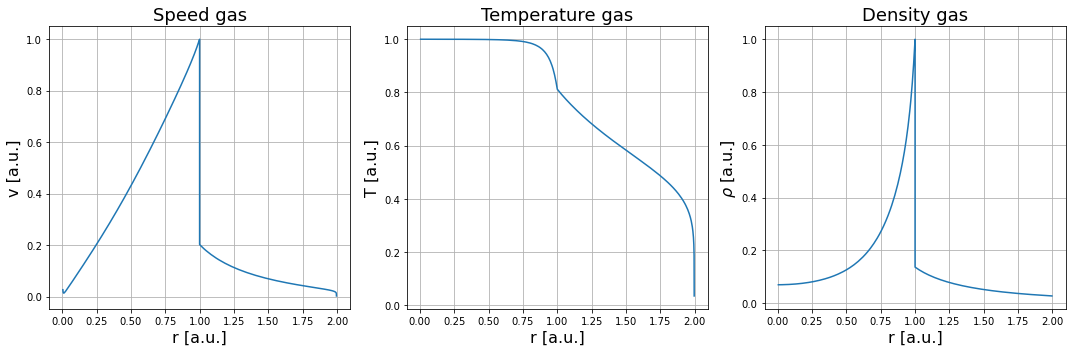

In [27]:
# Using the values found by the nested bisection schemes, we calculate the final solution and plot the physical quantities. 
sol_outer, sol_inner = integration(xi_found, xi_0, beta_found, 1e-3)
zeta_found = zeta(beta_found)
fig = plotPhysical(sol_outer, sol_inner, zeta_found, 1, normalise = True)
#fig.savefig('Physical quantities', dpi=400)

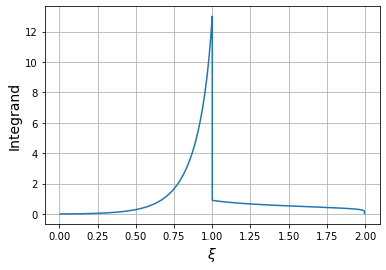

In [29]:
# A plot of the integrand used to calculate the strength of the explosion Omega. It is quite clear that the most important
# part is that just inside the shock front. Changing the inner radius to which we integrate therefore does not drastically
# change Omega.
# Serves mostly for edducational purposes, feel free to ignore.

xi, U, Theta, H, W, G = appendSolutions(sol_outer, sol_inner)

fig, ax = plt.subplots(1,1)
ax.plot(xi, xi**(n-k_p+1) * G * (U**2 + mu*Theta))
ax.set_xlabel('$\\xi$', fontsize=14)
ax.set_ylabel('Integrand', fontsize=14)
plt.grid()
plt.show()
fig.savefig('Integrand eq78', dpi=400)

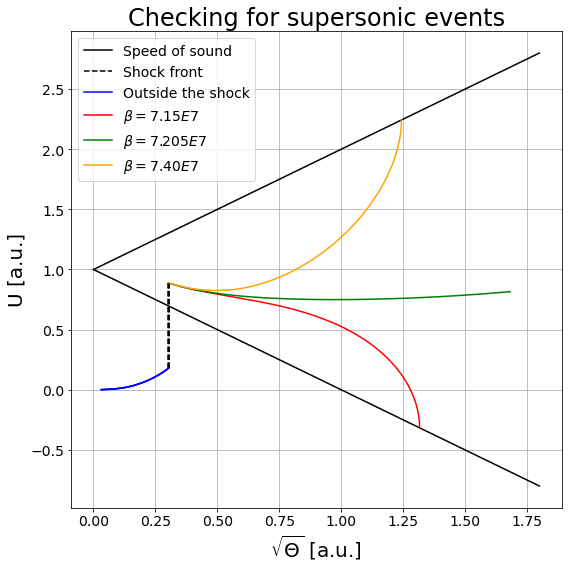

In [31]:
# More detailed plot of U-sqrt(Theta) plane that clearly shows the impact of changing beta_0 only slightly. 
# Serves mostly as an edducational example, feel free to ignore.

sol_out1, sol_in1 = integration(2, 0.2, 7.15e7, 10**-3)
sol_out2, sol_in2 = integration(2, 0.2, 7.205e7, 10**-3)
sol_out3, sol_in3 = integration(2, 0.2, 7.4e7, 10**-3)

fig, ax = plt.subplots(1,1, figsize=(8,8))

plt.plot([0, 1.8], [1, -0.8], color='black', label="Speed of sound")
plt.plot([0, 1.8], [1, 2.8], color='black')
plt.title("Checking for supersonic events", fontsize=24)
plt.xlabel("$\\sqrt{\\Theta}$ [a.u.]", fontsize=20)
plt.ylabel("U [a.u.]", fontsize=20)

plt.plot([np.sqrt(sol_out1.y[1][-1]), np.sqrt(sol_in1.y[1][0])], [sol_out1.y[0][-1], sol_in1.y[0][0]], 'k--', label="Shock front")
plt.plot(np.sqrt(sol_out1.y[1]), sol_out1.y[0], color='blue', label="Outside the shock")
plt.plot(np.sqrt(sol_in1.y[1]), sol_in1.y[0], color='red', label="$\\beta = 7.15E7$")

plt.plot(np.sqrt(sol_out2.y[1]), sol_out2.y[0], color='blue')
plt.plot(np.sqrt(sol_in2.y[1]), sol_in2.y[0], color='green', label="$\\beta = 7.205E7$")
plt.plot([np.sqrt(sol_out2.y[1][-1]), np.sqrt(sol_in2.y[1][0])], [sol_out2.y[0][-1], sol_in2.y[0][0]], 'k--')

plt.plot(np.sqrt(sol_out3.y[1]), sol_out3.y[0], color='blue')
plt.plot(np.sqrt(sol_in3.y[1]), sol_in3.y[0], color='orange', label="$\\beta = 7.40E7$")
plt.plot([np.sqrt(sol_out3.y[1][-1]), np.sqrt(sol_in3.y[1][0])], [sol_out3.y[0][-1], sol_in3.y[0][0]], 'k--')


plt.legend(fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.grid()             
plt.tight_layout()